## Final to be correct

In [33]:
import os
import pickle
import numpy as np
import mindspore
from mindspore import nn
from mindspore import dataset as ds
from mindspore.dataset import vision, transforms

path = './cifar-10-batches-py'

def load_cifar10_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    data = dict[b'data']
    labels = dict[b'labels']
    data = data.reshape(len(data), 3, 32, 32).transpose(0, 2, 3, 1)
    return data, labels

def load_cifar10(path):
    x_train = []
    y_train = []
    for i in range(1, 6):
        data, labels = load_cifar10_batch(os.path.join(path, f'data_batch_{i}'))
        x_train.append(data)
        y_train.append(labels)
    x_train = np.concatenate(x_train)
    y_train = np.concatenate(y_train)
    
    x_test, y_test = load_cifar10_batch(os.path.join(path, 'test_batch'))
    
    return (x_train, y_train), (x_test, y_test)

def create_dataset(data, labels, batch_size, shuffle=True):
    def generator():
        for i in range(len(data)):
            yield data[i], labels[i]

    dataset = ds.GeneratorDataset(generator, ["image", "label"], shuffle=shuffle)
    image_transforms = [
        vision.Rescale(1.0 / 255.0, 0),
        vision.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        vision.HWC2CHW()
    ]
    label_transform = transforms.TypeCast(mindspore.int32)
    
    dataset = dataset.map(operations=image_transforms, input_columns='image')
    dataset = dataset.map(operations=label_transform, input_columns='label')
    dataset = dataset.batch(batch_size)
    
    return dataset

(train_images, train_labels), (test_images, test_labels) = load_cifar10(path)
train_dataset = create_dataset(train_images, train_labels, batch_size=64)
test_dataset = create_dataset(test_images, test_labels, batch_size=64)

class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense_relu_sequential = nn.SequentialCell(
            nn.Dense(32*32*3, 512),
            nn.ReLU(),
            nn.Dense(512, 512),
            nn.ReLU(),
            nn.Dense(512, 10)
        )

    def construct(self, x):
        x = self.flatten(x)
        logits = self.dense_relu_sequential(x)
        return logits

model = Network()
epochs = 3
batch_size = 64
learning_rate = 1e-2
loss_fn = nn.CrossEntropyLoss()
optimizer = nn.SGD(model.trainable_params(), learning_rate=learning_rate)

# Define forward function
def forward_fn(data, label):
    logits = model(data)
    loss = loss_fn(logits, label)
    return loss, logits

# Get gradient function
grad_fn = mindspore.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

# Define function of one-step training
def train_step(data, label):
    (loss, _), grads = grad_fn(data, label)
    optimizer(grads)
    return loss

def train_loop(model, dataset):
    size = dataset.get_dataset_size()
    model.set_train()
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)

        if batch % 100 == 0:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")

def test_loop(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        correct += (pred.argmax(1) == label).asnumpy().sum()
    test_loss /= num_batches
    correct /= total
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

loss_fn = nn.CrossEntropyLoss()
optimizer = nn.SGD(model.trainable_params(), learning_rate=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(model, train_dataset)
    test_loop(model, test_dataset, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 2.304152  [  0/782]
loss: 2.027038  [100/782]
loss: 1.766113  [200/782]
loss: 1.880531  [300/782]
loss: 1.818431  [400/782]
loss: 1.851951  [500/782]
loss: 1.773557  [600/782]
loss: 1.680258  [700/782]
Test: 
 Accuracy: 42.0%, Avg loss: 1.646286 

Epoch 2
-------------------------------
loss: 1.615075  [  0/782]
loss: 1.590012  [100/782]
loss: 1.316776  [200/782]
loss: 1.691302  [300/782]
loss: 1.583438  [400/782]
loss: 1.655619  [500/782]
loss: 1.610360  [600/782]
loss: 1.555986  [700/782]
Test: 
 Accuracy: 45.7%, Avg loss: 1.541376 

Epoch 3
-------------------------------
loss: 1.502752  [  0/782]
loss: 1.455833  [100/782]
loss: 1.201244  [200/782]
loss: 1.594164  [300/782]
loss: 1.472840  [400/782]
loss: 1.555792  [500/782]
loss: 1.540589  [600/782]
loss: 1.487271  [700/782]
Test: 
 Accuracy: 48.2%, Avg loss: 1.473512 

Done!


## Add the detailed information of the processing of training

In [34]:
import os
import pickle
import numpy as np
import mindspore
from mindspore import nn
from mindspore import dataset as ds
from mindspore.dataset import vision, transforms

path = './cifar-10-batches-py'

def load_cifar10_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    data = dict[b'data']
    labels = dict[b'labels']
    data = data.reshape(len(data), 3, 32, 32).transpose(0, 2, 3, 1)
    return data, labels

def load_cifar10(path):
    x_train = []
    y_train = []
    for i in range(1, 6):
        data, labels = load_cifar10_batch(os.path.join(path, f'data_batch_{i}'))
        x_train.append(data)
        y_train.append(labels)
    x_train = np.concatenate(x_train)
    y_train = np.concatenate(y_train)
    
    x_test, y_test = load_cifar10_batch(os.path.join(path, 'test_batch'))
    
    return (x_train, y_train), (x_test, y_test)

def create_dataset(data, labels, batch_size, shuffle=True):
    def generator():
        for i in range(len(data)):
            yield data[i], labels[i]

    dataset = ds.GeneratorDataset(generator, ["image", "label"], shuffle=shuffle)
    image_transforms = [
        vision.Rescale(1.0 / 255.0, 0),
        vision.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        vision.HWC2CHW()
    ]
    label_transform = transforms.TypeCast(mindspore.int32)
    
    dataset = dataset.map(operations=image_transforms, input_columns='image')
    dataset = dataset.map(operations=label_transform, input_columns='label')
    dataset = dataset.batch(batch_size)
    
    return dataset

(train_images, train_labels), (test_images, test_labels) = load_cifar10(path)
train_dataset = create_dataset(train_images, train_labels, batch_size=64)
test_dataset = create_dataset(test_images, test_labels, batch_size=64)

class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense_relu_sequential = nn.SequentialCell(
            nn.Dense(32*32*3, 512),
            nn.ReLU(),
            nn.Dense(512, 512),
            nn.ReLU(),
            nn.Dense(512, 10)
        )

    def construct(self, x):
        x = self.flatten(x)
        logits = self.dense_relu_sequential(x)
        return logits

model = Network()
epochs = 3
batch_size = 64
learning_rate = 1e-2
loss_fn = nn.CrossEntropyLoss()
optimizer = nn.SGD(model.trainable_params(), learning_rate=learning_rate)

# Define forward function
def forward_fn(data, label):
    logits = model(data)
    loss = loss_fn(logits, label)
    return loss, logits

# Get gradient function
grad_fn = mindspore.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

# Define function of one-step training
def train_step(data, label):
    (loss, _), grads = grad_fn(data, label)
    optimizer(grads)
    return loss

def train_loop(model, dataset):
    size = dataset.get_dataset_size()
    model.set_train()
    total_loss = 0
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)
        total_loss += loss.asnumpy()

        if batch % 100 == 0:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")
    
    return total_loss / size

def test_loop(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        correct += (pred.argmax(1) == label).asnumpy().sum()
    test_loss /= num_batches
    correct /= total
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(model, train_dataset)
    test_loss, test_accuracy = test_loop(model, test_dataset, loss_fn)
    print(f"Epoch {t+1} Summary: \n Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}, Test Accuracy: {test_accuracy*100:.2f}%\n")
print("Done!")


Epoch 1
-------------------------------


[WARNING] ME(18628:10296,MainProcess):2024-05-30-10:52:22.517.390 [mindspore\common\api.py:466] The function "after_grad" at the file "d:\anaconda\envs\mindspore\lib\site-packages\mindspore\ops\composite\base.py", line 587 has been compiled again. Try to decorate the function with @jit(hash_args=...) or @jit(compile_once=True) to reduce the compile time. For more details, get instructions about `jit` at https://www.mindspore.cn/search?inputValue=jit. 


loss: 2.295036  [  0/782]
loss: 2.043537  [100/782]
loss: 1.764434  [200/782]
loss: 1.878247  [300/782]
loss: 1.821717  [400/782]
loss: 1.851928  [500/782]
loss: 1.777689  [600/782]
loss: 1.673947  [700/782]
Test: 
 Accuracy: 42.6%, Avg loss: 1.642519 

Epoch 1 Summary: 
 Train Loss: 1.822299, Test Loss: 1.642519, Test Accuracy: 42.60%

Epoch 2
-------------------------------
loss: 1.611290  [  0/782]
loss: 1.590575  [100/782]
loss: 1.308581  [200/782]
loss: 1.683626  [300/782]
loss: 1.587054  [400/782]
loss: 1.658285  [500/782]
loss: 1.617186  [600/782]
loss: 1.547086  [700/782]
Test: 
 Accuracy: 45.7%, Avg loss: 1.539881 

Epoch 2 Summary: 
 Train Loss: 1.572496, Test Loss: 1.539881, Test Accuracy: 45.66%

Epoch 3
-------------------------------
loss: 1.501256  [  0/782]
loss: 1.467619  [100/782]
loss: 1.193904  [200/782]
loss: 1.581551  [300/782]
loss: 1.492094  [400/782]
loss: 1.570631  [500/782]
loss: 1.539012  [600/782]
loss: 1.465616  [700/782]
Test: 
 Accuracy: 48.4%, Avg loss:

## Add loss and accuracy Curves

Epoch 1
-------------------------------


[WARNING] ME(18628:10296,MainProcess):2024-05-30-10:53:39.374.491 [mindspore\common\api.py:466] The function "after_grad" at the file "d:\anaconda\envs\mindspore\lib\site-packages\mindspore\ops\composite\base.py", line 587 has been compiled again. Try to decorate the function with @jit(hash_args=...) or @jit(compile_once=True) to reduce the compile time. For more details, get instructions about `jit` at https://www.mindspore.cn/search?inputValue=jit. 


loss: 2.310251  [  0/782]
loss: 2.052357  [100/782]
loss: 1.762802  [200/782]
loss: 1.879480  [300/782]
loss: 1.849494  [400/782]
loss: 1.868626  [500/782]
loss: 1.784037  [600/782]
loss: 1.647797  [700/782]
Test: 
 Accuracy: 42.7%, Avg loss: 1.644731 

Epoch 1 Summary: 
 Train Loss: 1.828229, Test Loss: 1.644731, Test Accuracy: 42.72%

Epoch 2
-------------------------------
loss: 1.617110  [  0/782]
loss: 1.606265  [100/782]
loss: 1.309992  [200/782]
loss: 1.704660  [300/782]
loss: 1.611506  [400/782]
loss: 1.661176  [500/782]
loss: 1.603321  [600/782]
loss: 1.522271  [700/782]
Test: 
 Accuracy: 46.1%, Avg loss: 1.535970 

Epoch 2 Summary: 
 Train Loss: 1.573745, Test Loss: 1.535970, Test Accuracy: 46.11%

Epoch 3
-------------------------------
loss: 1.494518  [  0/782]
loss: 1.474121  [100/782]
loss: 1.198460  [200/782]
loss: 1.608538  [300/782]
loss: 1.499926  [400/782]
loss: 1.578090  [500/782]
loss: 1.528571  [600/782]
loss: 1.477385  [700/782]
Test: 
 Accuracy: 48.3%, Avg loss:

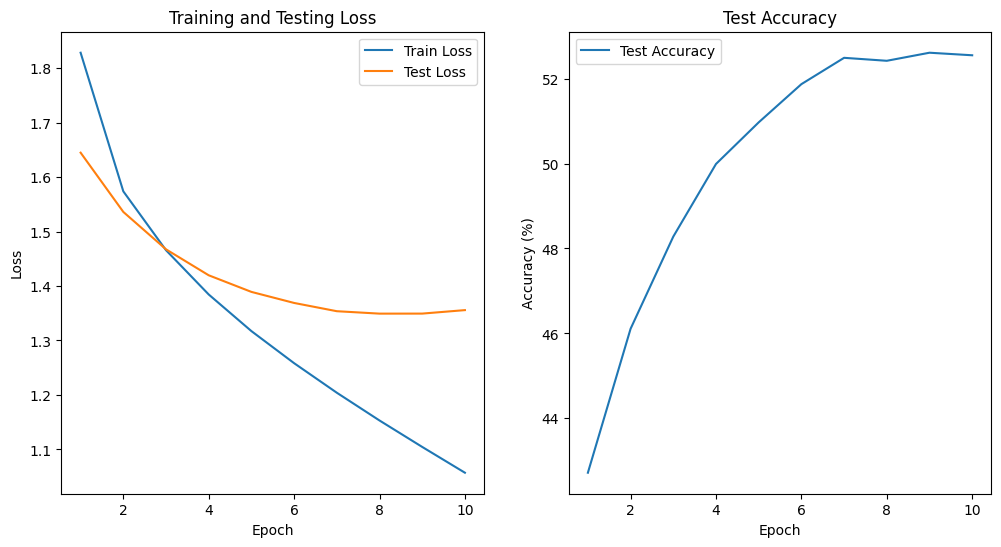

In [35]:
import os
import pickle
import numpy as np
import mindspore
from mindspore import nn
from mindspore import dataset as ds
from mindspore.dataset import vision, transforms
import matplotlib.pyplot as plt

path = './cifar-10-batches-py'

def load_cifar10_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    data = dict[b'data']
    labels = dict[b'labels']
    data = data.reshape(len(data), 3, 32, 32).transpose(0, 2, 3, 1)
    return data, labels

def load_cifar10(path):
    x_train = []
    y_train = []
    for i in range(1, 6):
        data, labels = load_cifar10_batch(os.path.join(path, f'data_batch_{i}'))
        x_train.append(data)
        y_train.append(labels)
    x_train = np.concatenate(x_train)
    y_train = np.concatenate(y_train)
    
    x_test, y_test = load_cifar10_batch(os.path.join(path, 'test_batch'))
    
    return (x_train, y_train), (x_test, y_test)

def create_dataset(data, labels, batch_size, shuffle=True):
    def generator():
        for i in range(len(data)):
            yield data[i], labels[i]

    dataset = ds.GeneratorDataset(generator, ["image", "label"], shuffle=shuffle)
    image_transforms = [
        vision.Rescale(1.0 / 255.0, 0),
        vision.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        vision.HWC2CHW()
    ]
    label_transform = transforms.TypeCast(mindspore.int32)
    
    dataset = dataset.map(operations=image_transforms, input_columns='image')
    dataset = dataset.map(operations=label_transform, input_columns='label')
    dataset = dataset.batch(batch_size)
    
    return dataset

(train_images, train_labels), (test_images, test_labels) = load_cifar10(path)
train_dataset = create_dataset(train_images, train_labels, batch_size=64)
test_dataset = create_dataset(test_images, test_labels, batch_size=64)

class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense_relu_sequential = nn.SequentialCell(
            nn.Dense(32*32*3, 512),
            nn.ReLU(),
            nn.Dense(512, 512),
            nn.ReLU(),
            nn.Dense(512, 10)
        )

    def construct(self, x):
        x = self.flatten(x)
        logits = self.dense_relu_sequential(x)
        return logits

model = Network()
epochs = 10
batch_size = 64
learning_rate = 1e-2
loss_fn = nn.CrossEntropyLoss()
optimizer = nn.SGD(model.trainable_params(), learning_rate=learning_rate)

# Define forward function
def forward_fn(data, label):
    logits = model(data)
    loss = loss_fn(logits, label)
    return loss, logits

# Get gradient function
grad_fn = mindspore.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

# Define function of one-step training
def train_step(data, label):
    (loss, _), grads = grad_fn(data, label)
    optimizer(grads)
    return loss

def train_loop(model, dataset):
    size = dataset.get_dataset_size()
    model.set_train()
    total_loss = 0
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)
        total_loss += loss.asnumpy()

        if batch % 100 == 0:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")
    
    return total_loss / size

def test_loop(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        correct += (pred.argmax(1) == label).asnumpy().sum()
    test_loss /= num_batches
    correct /= total
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

train_losses = []
test_losses = []
test_accuracies = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(model, train_dataset)
    test_loss, test_accuracy = test_loop(model, test_dataset, loss_fn)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f"Epoch {t+1} Summary: \n Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}, Test Accuracy: {test_accuracy*100:.2f}%\n")
print("Done!")

# Plotting
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, [acc * 100 for acc in test_accuracies], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()

plt.show()


## Add Confusion Matrix(self made)

Epoch 1
-------------------------------


[WARNING] ME(18628:10296,MainProcess):2024-05-30-11:04:34.395.59 [mindspore\common\api.py:466] The function "after_grad" at the file "d:\anaconda\envs\mindspore\lib\site-packages\mindspore\ops\composite\base.py", line 587 has been compiled again. Try to decorate the function with @jit(hash_args=...) or @jit(compile_once=True) to reduce the compile time. For more details, get instructions about `jit` at https://www.mindspore.cn/search?inputValue=jit. 


loss: 2.297286  [  0/782]
loss: 2.041988  [100/782]
loss: 1.776957  [200/782]
loss: 1.915632  [300/782]
loss: 1.842617  [400/782]
loss: 1.849342  [500/782]
loss: 1.807150  [600/782]
loss: 1.689213  [700/782]
Test: 
 Accuracy: 42.8%, Avg loss: 1.641095 

Epoch 1 Summary: 
 Train Loss: 1.825943, Test Loss: 1.641095, Test Accuracy: 42.78%

Epoch 2
-------------------------------
loss: 1.623924  [  0/782]
loss: 1.603322  [100/782]
loss: 1.333508  [200/782]
loss: 1.722116  [300/782]
loss: 1.592996  [400/782]
loss: 1.650909  [500/782]
loss: 1.630997  [600/782]
loss: 1.568723  [700/782]
Test: 
 Accuracy: 45.9%, Avg loss: 1.535973 

Epoch 2 Summary: 
 Train Loss: 1.568742, Test Loss: 1.535973, Test Accuracy: 45.87%

Epoch 3
-------------------------------
loss: 1.497342  [  0/782]
loss: 1.462916  [100/782]
loss: 1.216041  [200/782]
loss: 1.634837  [300/782]
loss: 1.490428  [400/782]
loss: 1.581653  [500/782]
loss: 1.565920  [600/782]
loss: 1.497627  [700/782]
Test: 
 Accuracy: 48.3%, Avg loss:

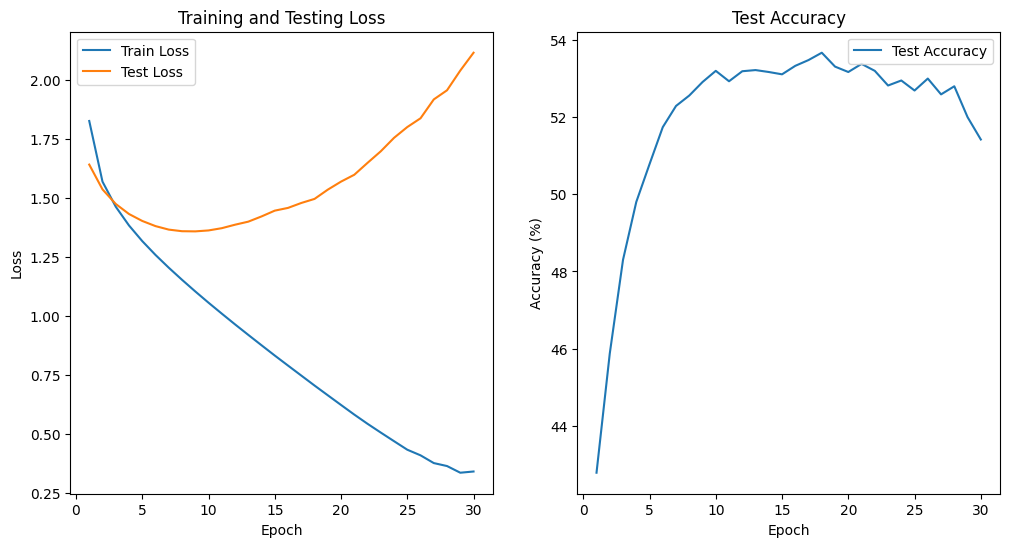

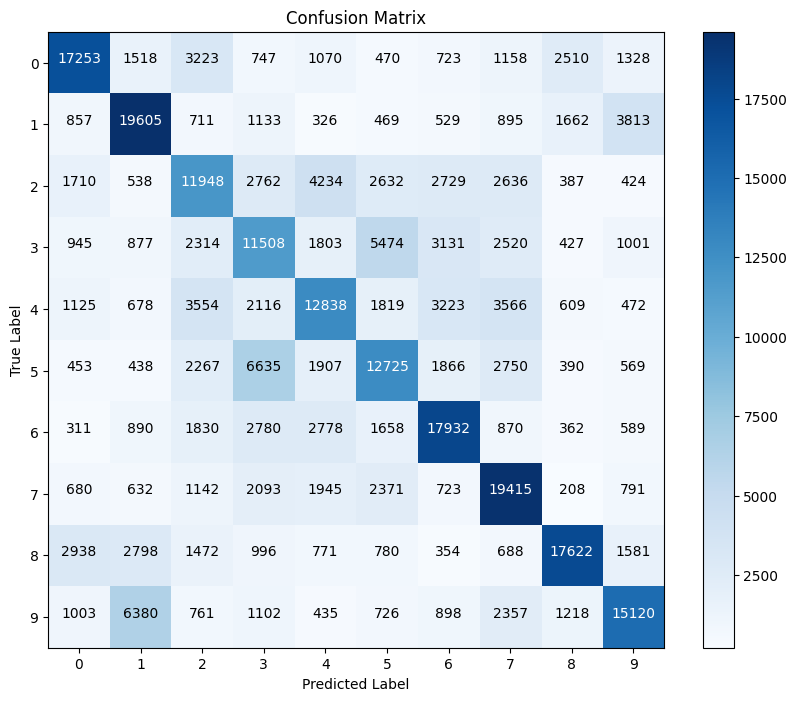

In [37]:
import os
import pickle
import numpy as np
import mindspore
from mindspore import nn
from mindspore import dataset as ds
from mindspore.dataset import vision, transforms
import matplotlib.pyplot as plt

path = './cifar-10-batches-py'

def load_cifar10_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    data = dict[b'data']
    labels = dict[b'labels']
    data = data.reshape(len(data), 3, 32, 32).transpose(0, 2, 3, 1)
    return data, labels

def load_cifar10(path):
    x_train = []
    y_train = []
    for i in range(1, 6):
        data, labels = load_cifar10_batch(os.path.join(path, f'data_batch_{i}'))
        x_train.append(data)
        y_train.append(labels)
    x_train = np.concatenate(x_train)
    y_train = np.concatenate(y_train)
    
    x_test, y_test = load_cifar10_batch(os.path.join(path, 'test_batch'))
    
    return (x_train, y_train), (x_test, y_test)

def create_dataset(data, labels, batch_size, shuffle=True):
    def generator():
        for i in range(len(data)):
            yield data[i], labels[i]

    dataset = ds.GeneratorDataset(generator, ["image", "label"], shuffle=shuffle)
    image_transforms = [
        vision.Rescale(1.0 / 255.0, 0),
        vision.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        vision.HWC2CHW()
    ]
    label_transform = transforms.TypeCast(mindspore.int32)
    
    dataset = dataset.map(operations=image_transforms, input_columns='image')
    dataset = dataset.map(operations=label_transform, input_columns='label')
    dataset = dataset.batch(batch_size)
    
    return dataset

(train_images, train_labels), (test_images, test_labels) = load_cifar10(path)
train_dataset = create_dataset(train_images, train_labels, batch_size=64)
test_dataset = create_dataset(test_images, test_labels, batch_size=64)

class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense_relu_sequential = nn.SequentialCell(
            nn.Dense(32*32*3, 512),
            nn.ReLU(),
            nn.Dense(512, 512),
            nn.ReLU(),
            nn.Dense(512, 10)
        )

    def construct(self, x):
        x = self.flatten(x)
        logits = self.dense_relu_sequential(x)
        return logits

model = Network()
epochs = 30
batch_size = 64
learning_rate = 1e-2
loss_fn = nn.CrossEntropyLoss()
optimizer = nn.SGD(model.trainable_params(), learning_rate=learning_rate)

# Define forward function
def forward_fn(data, label):
    logits = model(data)
    loss = loss_fn(logits, label)
    return loss, logits

# Get gradient function
grad_fn = mindspore.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

# Define function of one-step training
def train_step(data, label):
    (loss, _), grads = grad_fn(data, label)
    optimizer(grads)
    return loss

def train_loop(model, dataset):
    size = dataset.get_dataset_size()
    model.set_train()
    total_loss = 0
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)
        total_loss += loss.asnumpy()

        if batch % 100 == 0:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")
    
    return total_loss / size

def test_loop(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    all_preds = []
    all_labels = []
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        correct += (pred.argmax(1) == label).asnumpy().sum()
        all_preds.extend(pred.argmax(1).asnumpy())
        all_labels.extend(label.asnumpy())
    test_loss /= num_batches
    correct /= total
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct, all_preds, all_labels

def compute_confusion_matrix(y_true, y_pred, num_classes):
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
    for true, pred in zip(y_true, y_pred):
        conf_matrix[true, pred] += 1
    return conf_matrix

train_losses = []
test_losses = []
test_accuracies = []
all_preds = []
all_labels = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(model, train_dataset)
    test_loss, test_accuracy, epoch_preds, epoch_labels = test_loop(model, test_dataset, loss_fn)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    all_preds.extend(epoch_preds)
    all_labels.extend(epoch_labels)
    print(f"Epoch {t+1} Summary: \n Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}, Test Accuracy: {test_accuracy*100:.2f}%\n")
print("Done!")

# Plotting
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, [acc * 100 for acc in test_accuracies], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()

plt.show()

# Confusion Matrix
conf_matrix = compute_confusion_matrix(all_labels, all_preds, 10)
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations to the confusion matrix
thresh = conf_matrix.max() / 2
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if conf_matrix[i, j] > thresh else 'black')

plt.show()


## Unified the training output information and improved the confusion matrix

Epoch [0], train_loss: 1.8253, val_loss: 1.6414, val_acc: 0.4254
Epoch [1], train_loss: 1.5711, val_loss: 1.5310, val_acc: 0.4598
Epoch [2], train_loss: 1.4628, val_loss: 1.4645, val_acc: 0.4833
Epoch [3], train_loss: 1.3817, val_loss: 1.4183, val_acc: 0.5027
Epoch [4], train_loss: 1.3151, val_loss: 1.3889, val_acc: 0.5106
Epoch [5], train_loss: 1.2565, val_loss: 1.3680, val_acc: 0.5185
Epoch [6], train_loss: 1.2024, val_loss: 1.3512, val_acc: 0.5256
Epoch [7], train_loss: 1.1512, val_loss: 1.3392, val_acc: 0.5315
Epoch [8], train_loss: 1.1025, val_loss: 1.3366, val_acc: 0.5357
Epoch [9], train_loss: 1.0552, val_loss: 1.3381, val_acc: 0.5365
Done!


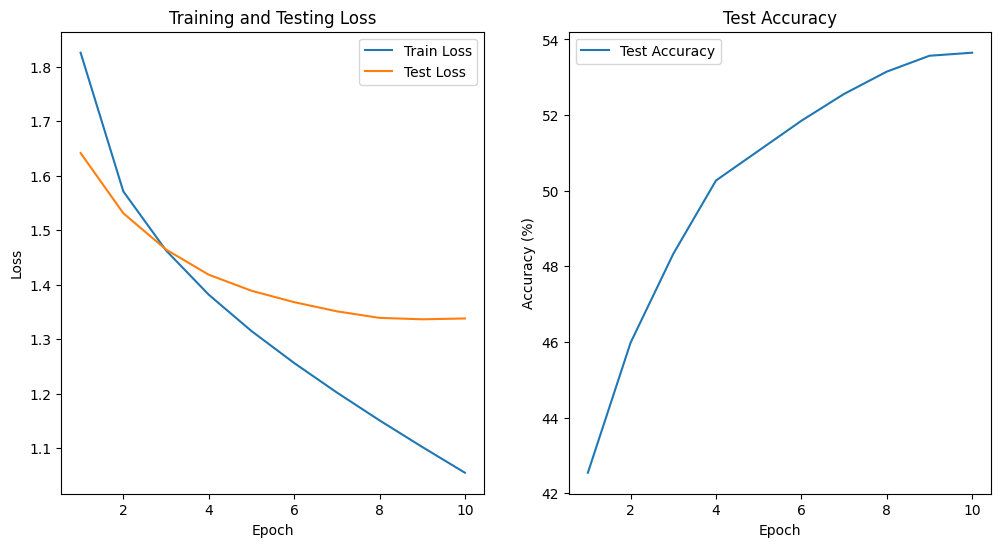

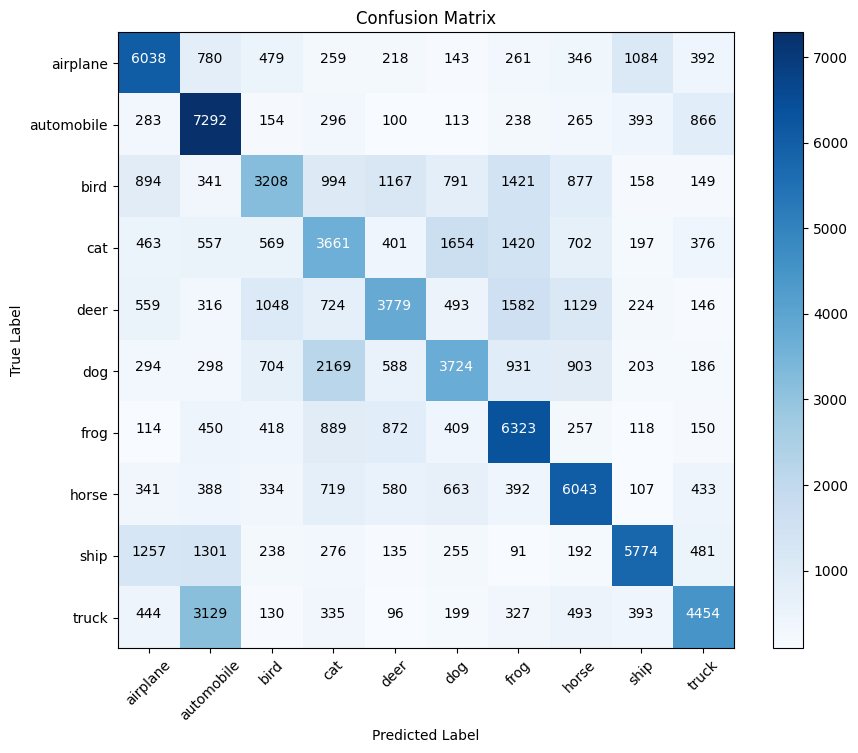

In [1]:
import os
import pickle
import numpy as np
import mindspore
from mindspore import nn
from mindspore import dataset as ds
from mindspore.dataset import vision, transforms
import matplotlib.pyplot as plt

path = './cifar-10-batches-py'

def load_cifar10_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    data = dict[b'data']
    labels = dict[b'labels']
    data = data.reshape(len(data), 3, 32, 32).transpose(0, 2, 3, 1)
    return data, labels

def load_cifar10(path):
    x_train = []
    y_train = []
    for i in range(1, 6):
        data, labels = load_cifar10_batch(os.path.join(path, f'data_batch_{i}'))
        x_train.append(data)
        y_train.append(labels)
    x_train = np.concatenate(x_train)
    y_train = np.concatenate(y_train)
    
    x_test, y_test = load_cifar10_batch(os.path.join(path, 'test_batch'))
    
    return (x_train, y_train), (x_test, y_test)

def create_dataset(data, labels, batch_size, shuffle=True):
    def generator():
        for i in range(len(data)):
            yield data[i], labels[i]

    dataset = ds.GeneratorDataset(generator, ["image", "label"], shuffle=shuffle)
    image_transforms = [
        vision.Rescale(1.0 / 255.0, 0),
        vision.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        vision.HWC2CHW()
    ]
    label_transform = transforms.TypeCast(mindspore.int32)
    
    dataset = dataset.map(operations=image_transforms, input_columns='image')
    dataset = dataset.map(operations=label_transform, input_columns='label')
    dataset = dataset.batch(batch_size)
    
    return dataset

(train_images, train_labels), (test_images, test_labels) = load_cifar10(path)
train_dataset = create_dataset(train_images, train_labels, batch_size=64)
test_dataset = create_dataset(test_images, test_labels, batch_size=64)

class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense_relu_sequential = nn.SequentialCell(
            nn.Dense(32*32*3, 512),
            nn.ReLU(),
            nn.Dense(512, 512),
            nn.ReLU(),
            nn.Dense(512, 10)
        )

    def construct(self, x):
        x = self.flatten(x)
        logits = self.dense_relu_sequential(x)
        return logits

model = Network()
epochs = 10
batch_size = 64
learning_rate = 1e-2
loss_fn = nn.CrossEntropyLoss()
optimizer = nn.SGD(model.trainable_params(), learning_rate=learning_rate)

# Define forward function
def forward_fn(data, label):
    logits = model(data)
    loss = loss_fn(logits, label)
    return loss, logits

# Get gradient function
grad_fn = mindspore.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

# Define function of one-step training
def train_step(data, label):
    (loss, _), grads = grad_fn(data, label)
    optimizer(grads)
    return loss

def train_loop(model, dataset):
    size = dataset.get_dataset_size()
    model.set_train()
    total_loss = 0
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)
        total_loss += loss.asnumpy()
    
    return total_loss / size

def test_loop(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    all_preds = []
    all_labels = []
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        correct += (pred.argmax(1) == label).asnumpy().sum()
        all_preds.extend(pred.argmax(1).asnumpy())
        all_labels.extend(label.asnumpy())
    test_loss /= num_batches
    correct /= total
    return test_loss, correct, all_preds, all_labels

def compute_confusion_matrix(y_true, y_pred, num_classes):
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
    for true, pred in zip(y_true, y_pred):
        conf_matrix[true, pred] += 1
    return conf_matrix

train_losses = []
test_losses = []
test_accuracies = []
all_preds = []
all_labels = []

for t in range(epochs):
    train_loss = train_loop(model, train_dataset)
    test_loss, test_accuracy, epoch_preds, epoch_labels = test_loop(model, test_dataset, loss_fn)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    all_preds.extend(epoch_preds)
    all_labels.extend(epoch_labels)
    print(f"Epoch [{t}], train_loss: {train_loss:.4f}, val_loss: {test_loss:.4f}, val_acc: {test_accuracy:.4f}")
print("Done!")

# Plotting
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, [acc * 100 for acc in test_accuracies], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()

plt.show()

# Confusion Matrix
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
conf_matrix = compute_confusion_matrix(all_labels, all_preds, 10)
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, cifar10_labels, rotation=45)
plt.yticks(tick_marks, cifar10_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations to the confusion matrix
thresh = conf_matrix.max() / 2
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if conf_matrix[i, j] > thresh else 'black')

plt.show()


Epoch [0], train_loss: 1.8252, val_loss: 1.6465, val_acc: 0.4230
Epoch [1], train_loss: 1.5716, val_loss: 1.5424, val_acc: 0.4540
Epoch [2], train_loss: 1.4662, val_loss: 1.4780, val_acc: 0.4809
Epoch [3], train_loss: 1.3857, val_loss: 1.4357, val_acc: 0.4938
Epoch [4], train_loss: 1.3193, val_loss: 1.4043, val_acc: 0.5075
Epoch [5], train_loss: 1.2613, val_loss: 1.3835, val_acc: 0.5130
Epoch [6], train_loss: 1.2076, val_loss: 1.3636, val_acc: 0.5223
Epoch [7], train_loss: 1.1568, val_loss: 1.3553, val_acc: 0.5267
Epoch [8], train_loss: 1.1083, val_loss: 1.3518, val_acc: 0.5288
Epoch [9], train_loss: 1.0611, val_loss: 1.3547, val_acc: 0.5267
Done!


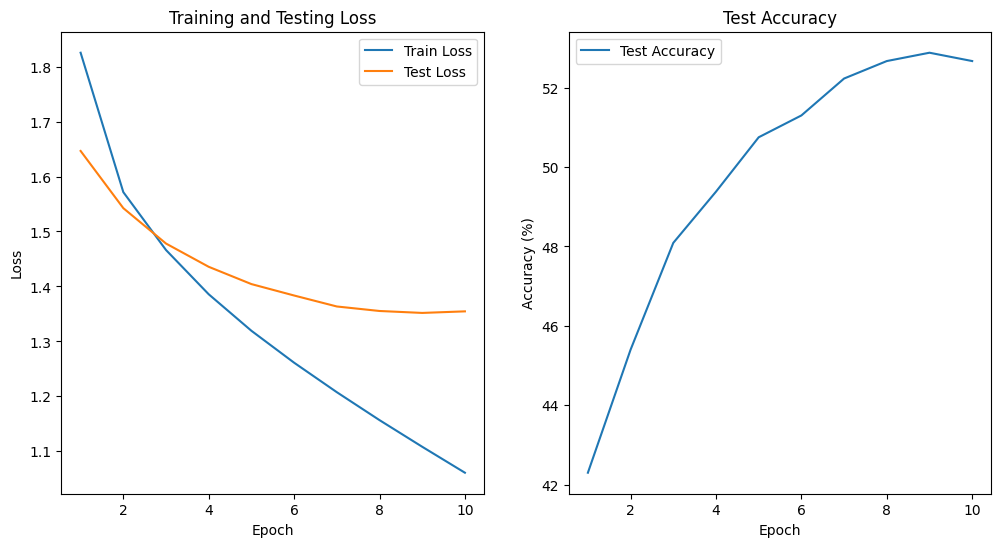

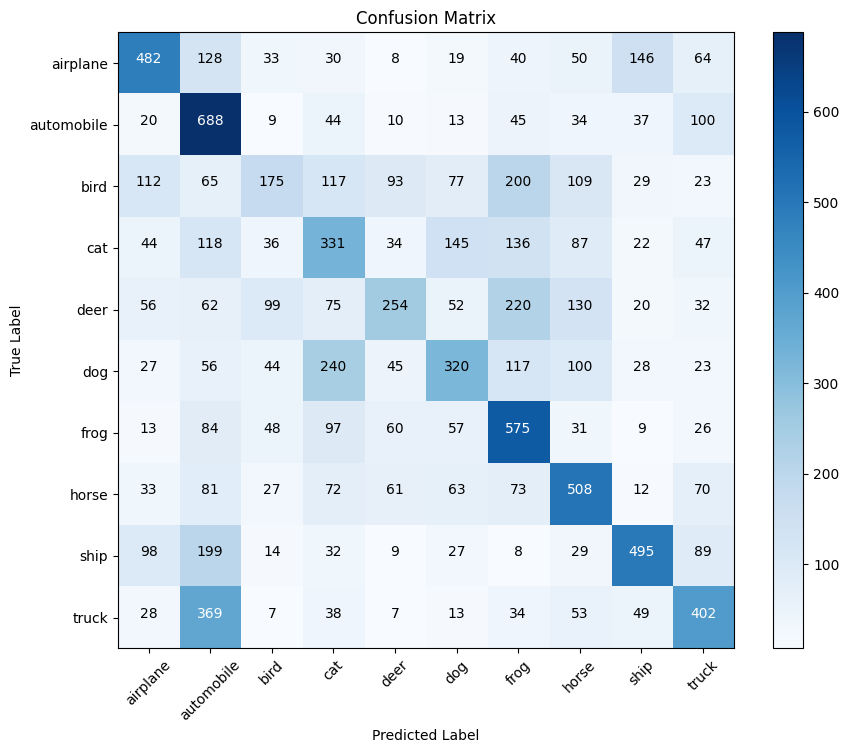

In [2]:
import os
import pickle
import numpy as np
import mindspore
from mindspore import nn
from mindspore import dataset as ds
from mindspore.dataset import vision, transforms
import matplotlib.pyplot as plt

path = './cifar-10-batches-py'

def load_cifar10_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    data = dict[b'data']
    labels = dict[b'labels']
    data = data.reshape(len(data), 3, 32, 32).transpose(0, 2, 3, 1)
    return data, labels

def load_cifar10(path):
    x_train = []
    y_train = []
    for i in range(1, 6):
        data, labels = load_cifar10_batch(os.path.join(path, f'data_batch_{i}'))
        x_train.append(data)
        y_train.append(labels)
    x_train = np.concatenate(x_train)
    y_train = np.concatenate(y_train)
    
    x_test, y_test = load_cifar10_batch(os.path.join(path, 'test_batch'))
    
    return (x_train, y_train), (x_test, y_test)

def create_dataset(data, labels, batch_size, shuffle=True):
    def generator():
        for i in range(len(data)):
            yield data[i], labels[i]

    dataset = ds.GeneratorDataset(generator, ["image", "label"], shuffle=shuffle)
    image_transforms = [
        vision.Rescale(1.0 / 255.0, 0),
        vision.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        vision.HWC2CHW()
    ]
    label_transform = transforms.TypeCast(mindspore.int32)
    
    dataset = dataset.map(operations=image_transforms, input_columns='image')
    dataset = dataset.map(operations=label_transform, input_columns='label')
    dataset = dataset.batch(batch_size)
    
    return dataset

(train_images, train_labels), (test_images, test_labels) = load_cifar10(path)
train_dataset = create_dataset(train_images, train_labels, batch_size=64)
test_dataset = create_dataset(test_images, test_labels, batch_size=64)

class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense_relu_sequential = nn.SequentialCell(
            nn.Dense(32*32*3, 512),
            nn.ReLU(),
            nn.Dense(512, 512),
            nn.ReLU(),
            nn.Dense(512, 10)
        )

    def construct(self, x):
        x = self.flatten(x)
        logits = self.dense_relu_sequential(x)
        return logits

model = Network()
epochs = 10
batch_size = 64
learning_rate = 1e-2
loss_fn = nn.CrossEntropyLoss()
optimizer = nn.SGD(model.trainable_params(), learning_rate=learning_rate)

# Define forward function
def forward_fn(data, label):
    logits = model(data)
    loss = loss_fn(logits, label)
    return loss, logits

# Get gradient function
grad_fn = mindspore.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

# Define function of one-step training
def train_step(data, label):
    (loss, _), grads = grad_fn(data, label)
    optimizer(grads)
    return loss

def train_loop(model, dataset):
    size = dataset.get_dataset_size()
    model.set_train()
    total_loss = 0
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)
        total_loss += loss.asnumpy()
    
    return total_loss / size

def test_loop(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    all_preds = []
    all_labels = []
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        correct += (pred.argmax(1) == label).asnumpy().sum()
        all_preds.extend(pred.argmax(1).asnumpy())
        all_labels.extend(label.asnumpy())
    test_loss /= num_batches
    correct /= total
    return test_loss, correct, all_preds, all_labels

def compute_confusion_matrix(y_true, y_pred, num_classes):
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
    for true, pred in zip(y_true, y_pred):
        conf_matrix[true, pred] += 1
    return conf_matrix

train_losses = []
test_losses = []
test_accuracies = []
all_preds = []
all_labels = []

for t in range(epochs):
    train_loss = train_loop(model, train_dataset)
    test_loss, test_accuracy, epoch_preds, epoch_labels = test_loop(model, test_dataset, loss_fn)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    all_preds.extend(epoch_preds)
    all_labels.extend(epoch_labels)
    print(f"Epoch [{t}], train_loss: {train_loss:.4f}, val_loss: {test_loss:.4f}, val_acc: {test_accuracy:.4f}")
print("Done!")

# Plotting
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, [acc * 100 for acc in test_accuracies], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()

plt.show()

# Confusion Matrix
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
conf_matrix = compute_confusion_matrix(all_labels[:10000], all_preds[:10000], 10)
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, cifar10_labels, rotation=45)
plt.yticks(tick_marks, cifar10_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations to the confusion matrix
thresh = conf_matrix.max() / 2
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if conf_matrix[i, j] > thresh else 'black')

plt.show()
